In [55]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from scipy import stats
from scipy.spatial import distance


In [2]:
ProteinCodCpgsAnnotations = pd.read_csv('ProteinCodCpgsAnnotations.csv')
ProteinCodCpgsAnnotations = ProteinCodCpgsAnnotations.set_index('probeID')

TrainMeth = pd.read_pickle('TrainMeth.pkl')
ValMeth = pd.read_pickle('ValMeth.pkl')

TrainTpm = pd.read_pickle('TrainTpm.pkl')
ValTpm = pd.read_pickle('ValTpm.pkl')

with open('CpgsGeneDict.pkl', 'rb') as f:
    CpgsGeneDict = pickle.load(f)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, median_absolute_error


TPMscaler = StandardScaler()
Methscaler = StandardScaler()

def plotCPG(SelectedCpg, model, axis):
    try:
        SelectedTranscripts = ProteinCodCpgsAnnotations.loc[SelectedCpg]['transcriptIDs'].split(';')
    except:
        SelectedTranscripts = ProteinCodCpgsAnnotations.loc['cg13466383']['transcriptIDs'].values
    QueryTranscript = pd.DataFrame()
    QueryTranscript['Transcript'] = ValTpm.T.loc[SelectedTranscripts].values[0]
    QueryTranscript.index = ValTpm.T.columns
    QueryTranscript.loc[:,"Group"] = QueryTranscript['Transcript'].apply(lambda x: "High" if x > np.median(QueryTranscript.values) else "Low")
    QueryTranscript.loc[:,"Meth"] =  ValMeth[SelectedCpg]
    model.fit(TPMscaler.fit_transform(TrainTpm[SelectedTranscripts].fillna(0)), TrainMeth[SelectedCpg].fillna(0))
    predictedMeth = model.predict(TPMscaler.transform(ValTpm[SelectedTranscripts].fillna(0)))
    QueryTranscript.loc[:,"Pred Meth"] =  predictedMeth
    sns.boxplot(pd.melt(QueryTranscript[['Group','Meth','Pred Meth']], id_vars='Group'), x='variable', y='value', hue='Group', ax=axis)
    plt.tight_layout()
    return QueryTranscript

In [56]:
AllCSVs = glob.glob("Results/*.csv")

In [166]:
CsvDf = pd.DataFrame()
for csv in AllCSVs:
    try:
        newCSV = pd.read_csv(csv, low_memory=False)
        CsvDf = pd.concat([CsvDf, newCSV])
    except:pass
CsvDf = CsvDf.drop('Unnamed: 0', axis=1).drop_duplicates(subset=['CPG','Model'], keep='first').set_index('CPG')

In [135]:
CsvDf = CsvDf.dropna(subset='PearsonR')

In [141]:
CsvDf = CsvDf[CsvDf['PearsonR'] >= 0]

In [147]:
CsvDf = CsvDf.sort_values(by=['PearsonR'], ascending=False)

In [155]:
CsvDf = CsvDf[~ CsvDf.index.duplicated(keep='first')]

In [194]:
CsvDf[CsvDf['PearsonR'] >= 0.45]['Model'].value_counts()

Model
GradientBoosting    10939
SVR                  9073
RandomForest 2       2551
Ridge                2296
DecisionTree         1625
Name: count, dtype: int64

In [190]:
CsvDf[CsvDf['PearsonR'] >= 0.4].index.value_counts()

CPG
cg18232597    5
cg25152942    5
cg03038262    5
cg02076355    5
cg17990365    5
             ..
cg07977178    1
cg22652406    1
cg23573567    1
cg04140971    1
cg09153080    1
Name: count, Length: 16811, dtype: int64

In [196]:
16811 / 250000 * 100

6.7244

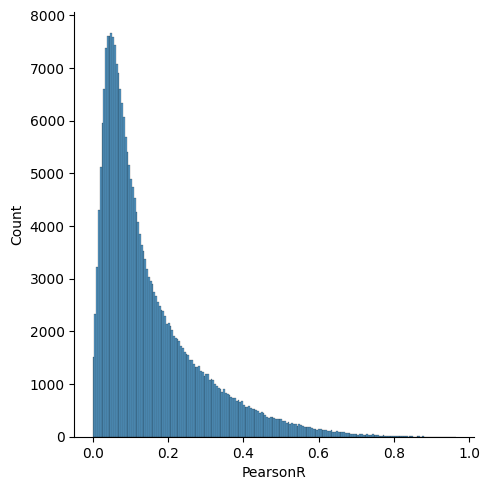

In [156]:
sns.displot(CsvDf['PearsonR'])

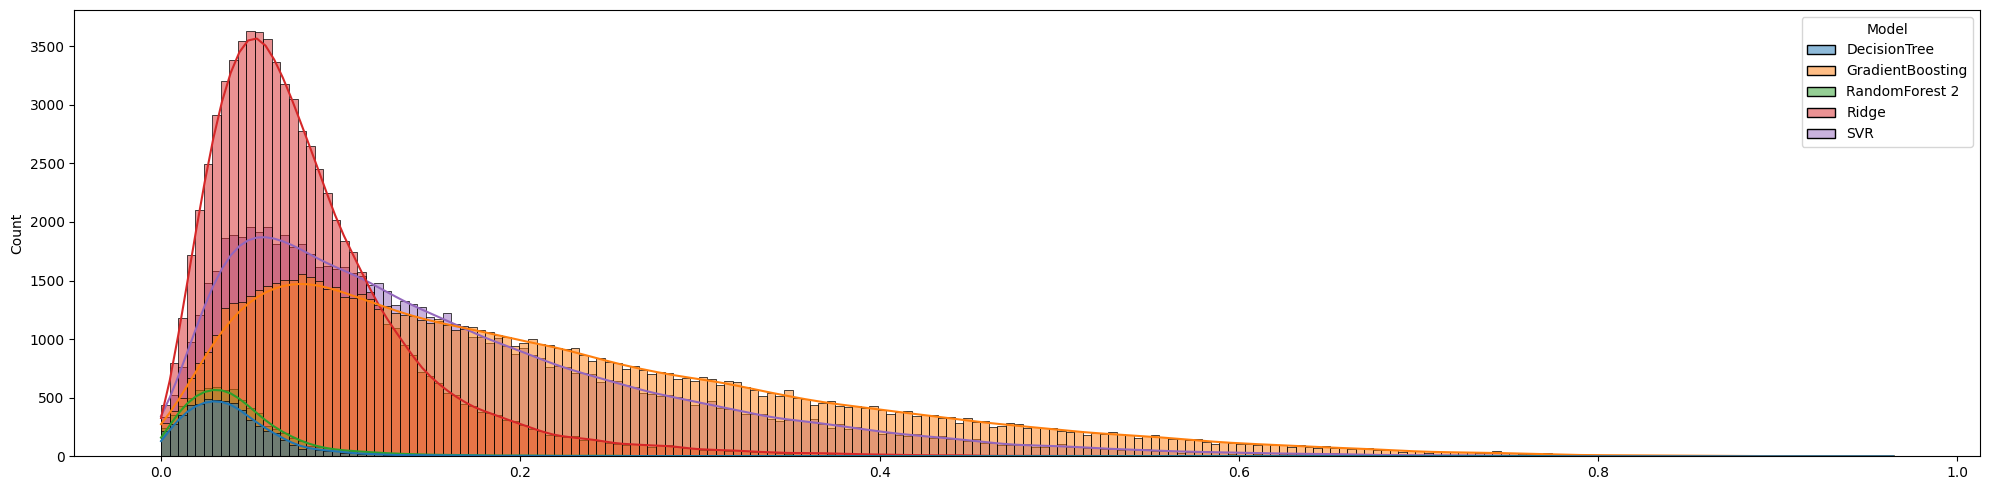

In [158]:
plt.figure(figsize=(20,5))
sns.histplot(pd.pivot(CsvDf[['PearsonR','Model']], columns='Model').droplevel(0, axis=1), kde=True)
plt.tight_layout()

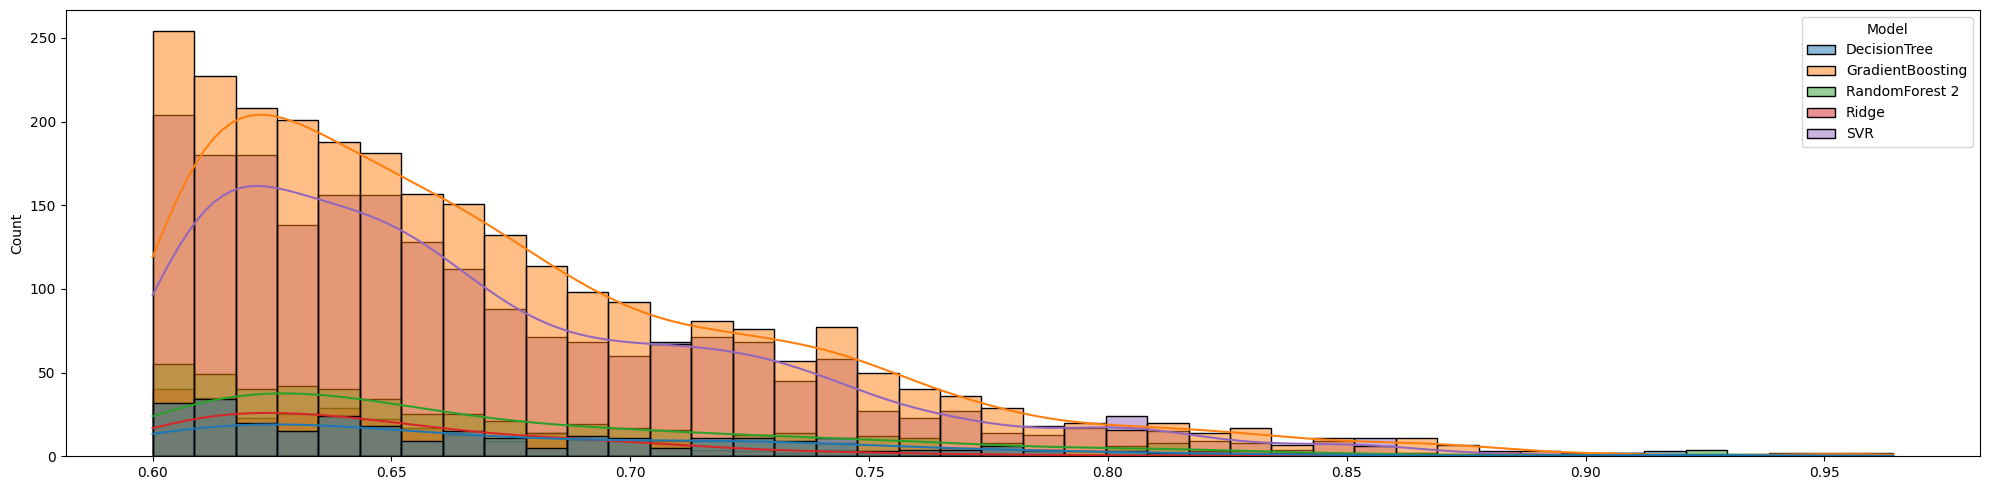

In [179]:
plt.figure(figsize=(20,5))
sns.histplot(pd.pivot(CsvDf[CsvDf['PearsonR'] > 0.6][['PearsonR','Model']], columns='Model').droplevel(0, axis=1), kde=True)
plt.tight_layout()

In [121]:
# CsvDf[(CsvDf['PearsonR'] >= 0.4) &(CsvDf['Model'].str.contains('Grad'))]
# CsvDf.loc[:, 'Abs Corr'] = round(CsvDf['PearsonR'],1)
# pd.DataFrame(CsvDf[['Model','Abs Corr']].value_counts()).sort_values(by='Abs Corr', ascending=False).head(50)

In [ ]:
TrainMeth = pd.read_pickle('TrainMeth.pkl')
ValMeth = pd.read_pickle('ValMeth.pkl')

TrainTpm = pd.read_pickle('TrainTpm.pkl')
ValTpm = pd.read_pickle('ValTpm.pkl')

In [ ]:
7000 / 250000 * 100

16.400000000000002

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


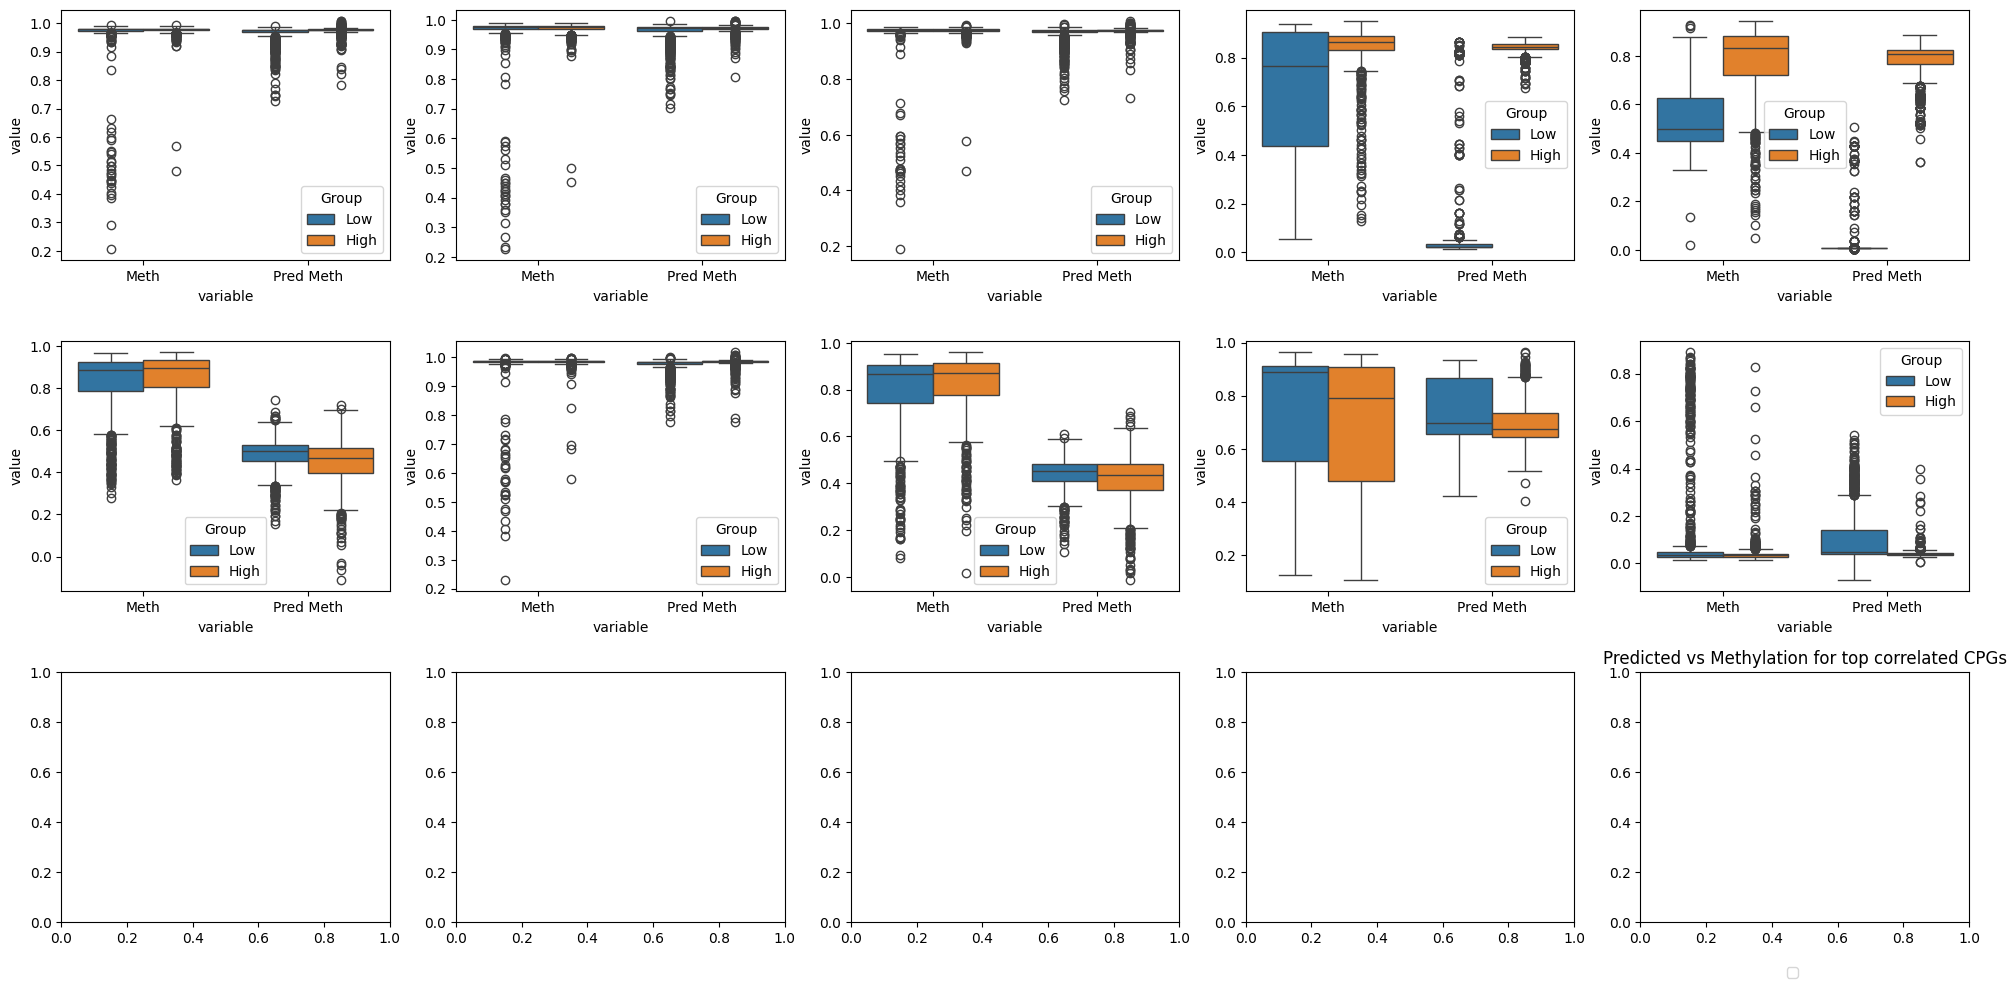

In [63]:
model = GradientBoostingRegressor(random_state=42)
# model = RandomForestRegressor(random_state=42, n_estimators=2, n_jobs=-1)
i = 0
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = list(axes.flatten())
for cpgs in CsvDf[(CsvDf['PearsonR'] > 0.9) & (CsvDf['Model'].str.contains('Grad'))].sort_values(by='PearsonR', ascending=False).index[:15]:
    ax = plotCPG(cpgs, model, axes[i])
    plt.title(f'{cpgs}')
    i += 1
plt.legend(bbox_to_anchor=(0.5,-0.15))
plt.title('Predicted vs Methylation for top correlated CPGs')
plt.tight_layout()

In [168]:
CsvDf[(CsvDf['PearsonR'] > 0.5) & (CsvDf['Model'].str.contains('Grad'))].sort_values(by='PearsonR', ascending=False)

,PearsonR,Euclidean Distance,RMSE,MSE,MAE,R2,P.Val,Model
CPG,,,,,,,,
cg27539721,0.964361,0.714562,0.015228,0.000232,0.005544,0.929440,0.000000e+00,GradientBoosting
cg09676606,0.963078,0.801140,0.017073,0.000291,0.009082,0.923434,0.000000e+00,GradientBoosting
cg10935064,0.955256,0.779060,0.016602,0.000276,0.004970,0.909774,0.000000e+00,GradientBoosting
cg01984154,0.948506,6.264285,0.133494,0.017821,0.061311,0.891711,0.000000e+00,GradientBoosting
cg08673225,0.944442,6.168760,0.131459,0.017281,0.067157,0.880621,0.000000e+00,GradientBoosting
...,...,...,...,...,...,...,...,...
cg13662644,0.500113,5.004271,0.106643,0.011373,0.047042,-1.374586,1.062562e-139,GradientBoosting
cg19533294,0.500110,8.451774,0.180111,0.032440,0.122683,-1.981691,1.068113e-139,GradientBoosting
cg08690999,0.500061,6.931656,0.147716,0.021820,0.111989,-1.359100,1.146776e-139,GradientBoosting


In [ ]:
CsvDf


,PearsonR,Euclidean Distance,RMSE,MSE,MAE,R2,P.Val,Model,Abs Corr
CPG,,,,,,,,,
cg18773844,0.161664,6.140443,0.130855,0.017123,0.094417,-1.299073e+01,2.309112e-14,Ridge,0.2
cg18773844,NaN,6.189556,0.131902,0.017398,0.095740,-4.897128e+12,NaN,Lasso,NaN
cg18773844,NaN,6.189556,0.131902,0.017398,0.095740,-4.897128e+12,NaN,ElasticNet,NaN
cg18773844,0.118232,8.216165,0.175090,0.030656,0.128311,-7.644324e-01,2.629351e-08,DecisionTree,0.1
cg18773844,0.104566,7.524947,0.160360,0.025715,0.118607,-1.286098e+00,8.764577e-07,RandomForest 2,0.1
...,...,...,...,...,...,...,...,...,...
cg04994761,NaN,8.558888,0.182393,0.033267,0.150153,0.000000e+00,NaN,ElasticNet,NaN
cg04994761,0.318483,9.651478,0.205677,0.042303,0.163915,-4.716185e-01,4.287504e-53,DecisionTree,0.3
cg04994761,0.368571,8.844799,0.188486,0.035527,0.149981,-6.040710e-01,8.200121e-72,RandomForest 2,0.4
